In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import matplotlib.ticker as ticker
import statsmodels.api as sm
from scipy import stats

## Data Analysis of ACS 20011-2021 survey using SQL and Python
## Data obtained from: https://usa.ipums.org/usa/index.shtml

#### Questions: 
##### - How has earnings among immigrants/non-immigrants changed?
##### - What helps determine the earnings of immigrants/non-immigrants?

In [2]:
# settings
plt.style.use('tableau-colorblind10')

In [3]:
# Helpers
mapping = {
    0: "Non-Immigrant",
    1: "Immigrant"
}

In [4]:
try:
    with open("password.txt", 'r') as f:
        pwd = f.read()
except FileNotFoundError:
    with open("password.txt", 'w') as f:
        pass

In [5]:
# Using SQL just as an excercise 
db = mysql.connector.connect(
    host = 'localhost', 
    user='root', 
    passwd = pwd,
    db='acs',
    allow_local_infile = True
)

In [6]:
mycursor = db.cursor()

In [17]:
# drop Acs table before creating the table
mycursor.execute("DROP TABLE Acs")

In [18]:
# Create table for ACS 2011 and 2021 data
mycursor.execute("""
CREATE TABLE Acs (
    ID INT PRIMARY KEY AUTO_INCREMENT, 
    YEAR INT,
    SAMPLE VARCHAR(100),
    SERIAL VARCHAR(100),
    HHWT INT,
    STRATA INT,
    GQ INT,
    PERNUM INT,
    PERWT INT,
    NCHILD INT,
    NCHLT5 INT,
    SEX SMALLINT UNSIGNED,
    AGE SMALLINT UNSIGNED,
    MARST SMALLINT UNSIGNED,
    RACE SMALLINT UNSIGNED,
    RACED INT,
    CITIZEN SMALLINT UNSIGNED,
    YRIMMIG INT,
    SPEAKENG SMALLINT UNSIGNED,
    SCHOOL SMALLINT UNSIGNED,
    EDUC SMALLINT UNSIGNED,
    EDUCD INT,
    EMPSTAT SMALLINT UNSIGNED,
    EMPSTATD INT,
    WKSWORK2 SMALLINT UNSIGNED,
    UHRSWORK INT,
    WRKLSTWK INT,
    INCTOT INT,
    INCWAGE INT
    )
""")

In [19]:
# Insert the data from the acs csv file
mycursor.execute("""
LOAD DATA LOCAL INFILE 'C:/Users/armym/Documents/sqlproject/usa_00007.csv' INTO TABLE Acs
FIELDS TERMINATED BY ',' 
LINES TERMINATED BY '\n'
IGNORE 1 ROWS
 (YEAR, 
 SAMPLE, 
 SERIAL, 
 @dummy, 
 HHWT,
 @dummy, 
 STRATA, 
 GQ, 
 PERNUM,
 PERWT,
 NCHILD, 
 NCHLT5, 
 SEX, 
 AGE, 
 MARST,
 RACE, 
 RACED, 
 CITIZEN, 
 YRIMMIG, 
 SPEAKENG,
 SCHOOL, 
 EDUC, 
 EDUCD,
 EMPSTAT, 
 EMPSTATD, 
 WKSWORK2, 
 UHRSWORK, 
 WRKLSTWK,
 INCTOT, 
 INCWAGE
 );
""")

In [8]:
sql_clean = """
SELECT ID, YEAR, NCHILD, NCHLT5, MARST,
    CASE SEX
        WHEN 1 then 0
        ELSE 1
    END as SEX_NEW,
    AGE,
    CASE 
        WHEN RACE=3 THEN 1
        WHEN RACE IN (4, 5) THEN 2
        WHEN RACE = 2 THEN 3
        WHEN RACE = 6 THEN 4
        WHEN RACE = 1 THEN 5
        ELSE 6
    END AS RACE_NEW,
    CASE 
        WHEN CITIZEN = 0 THEN 1
        WHEN CITIZEN NOT IN (0, 9) THEN 0
        ELSE NULL
    END AS CITIZEN_NEW,
    IF(YRIMMIG > 0, 1, 0) AS IMMIGRANT,
    CASE
        WHEN YRIMMIG = 0 THEN 1
        ELSE 0
    END AS USCITIZEN,
    CASE
        WHEN SPEAKENG IN (0, 1) THEN 0
        WHEN SPEAKENG >= 7 THEN NULL
        ELSE 1
    END AS SPEAKENG_NEW,
    SCHOOL,
    FORMAT(CASE EDUC
        WHEN 1 THEN 4
        WHEN 2 THEN 8
        WHEN 3 THEN 9
        WHEN 4 THEN 10
        WHEN 5 THEN 11
        WHEN 6 THEN 12
        WHEN 7 THEN 13
        WHEN 8 THEN 14
        WHEN 9 THEN 15
        WHEN 10 THEN 16
        WHEN 11 THEN 17
    END, 0) AS GRADE,
    
    CASE 
        WHEN EMPSTAT IN (0,2,3) THEN 0
        ELSE 1
    END AS EMPSTAT_NEW,
    
    WKSWORK2,
    YRIMMIG,
    IF(UHRSWORK=99, NULL, UHRSWORK) AS UHRSWORK_NEW,
    CASE 
        WHEN WRKLSTWK=2 THEN 1
        WHEN WRKLSTWK=1 THEN 2
        WHEN WRKLSTWK IN (0,3) THEN NULL
    END AS WRKLSTWK_NEW,
    
    IF(INCWAGE>=999999 , NULL, INCWAGE) AS INCWAGE_NEW

    FROM acs
    WHERE AGE BETWEEN 18 AND 55
"""
#     IF(EMPSTAT=1 AND UHRSWORK > 0 AND WRKLSTWK=1 AND INCWAGE>0, INCWAGE/WKSWORK2, NULL) AS WEEKLYEARNINGS

In [1]:
# create weekly earnings variable
# Note that INCWAGE_NEW is in contemporary dollars as per IPUMS.
def clean_acs_data():
    sql_clean2 = """
    WITH acs_cleaned as ({})
    SELECT *, IF(EMPSTAT_NEW=1 AND UHRSWORK_NEW > 0 AND WRKLSTWK_NEW=1 AND INCWAGE_NEW>0, INCWAGE_NEW/WKSWORK2, NULL) AS WEEKLYEARNINGS
    FROM acs_cleaned
    """.format(sql_clean)
    # convert sql_clean query into a pandas data frame
    df = pd.read_sql(sql_clean2, db)
    print(df.head())
    print("Shape: {}".format(df.shape))
    return df
df = clean_acs_data()

NameError: name 'sql_clean' is not defined

In [10]:
# alternitavley we create weekly earnings variable via pandas:
def create_weakly_earnings_var(df):
    def get_weakly_earnings(x):
        if x['EMPSTAT_NEW'] == 1 and x['UHRSWORK_NEW'] > 0 and x['WRKLSTWK_NEW'] == 1 and x['INCWAGE_NEW'] > 0:
            return x['INCWAGE_NEW'] / x['WKSWORK2']
    df['WEEKLYEARNINGS2'] = df.apply(get_weakly_earnings, axis = 1)
    return df
#df = create_weakly_earnings_var(df)

In [11]:
# being an immigrant and being a U.S born citizen means the individual was born in Puerto Rico, Guam, the U.S. Virgin Islands, or the Northern Marianas
print(df[df["YRIMMIG"]>0].shape)
df[(df["IMMIGRANT"]==1) & (df["CITIZEN_NEW"]==1)].head()

(1023080, 21)


,ID,YEAR,NCHILD,NCHLT5,MARST,SEX_NEW,AGE,RACE_NEW,CITIZEN_NEW,IMMIGRANT,...,SPEAKENG_NEW,SCHOOL,GRADE,EMPSTAT_NEW,WKSWORK2,YRIMMIG,UHRSWORK_NEW,WRKLSTWK_NEW,INCWAGE_NEW,WEEKLYEARNINGS
14,34,2011,2,0,1,1,41,3,1,1,...,1,1,16,1,6,1987,40.0,1.0,36900,6150.0000
219,478,2011,1,0,1,0,54,5,1,1,...,1,1,16,1,6,1958,40.0,1.0,89000,14833.3333
1040,2161,2011,0,0,1,0,52,4,1,1,...,1,1,12,1,2,1976,40.0,1.0,71000,35500.0000
1041,2162,2011,0,0,1,1,54,4,1,1,...,1,1,12,0,0,1976,0.0,2.0,0,NaN
1336,2779,2011,0,0,1,0,34,3,1,1,...,1,1,12,1,6,2004,45.0,1.0,41000,6833.3333


In [322]:
# Uncomment to drop acs_cleaned table
#mycursor.execute("DROP VIEW acs_cleaned")

In [327]:
# create view so we don't have to run sql_clean query again
columns = ', '.join(list(df.columns))
sql_clean2 = """
    WITH acs_cleaned as ({})
    SELECT *, IF(EMPSTAT_NEW=1 AND UHRSWORK_NEW > 0 AND WRKLSTWK_NEW=1 AND INCWAGE_NEW>0, INCWAGE_NEW/WKSWORK2, NULL) AS WEEKLYEARNINGS
    FROM acs_cleaned
    """.format(sql_clean)

mycursor.execute(
    f"""CREATE VIEW acs_cleaned
        ({columns})
        AS
        {sql_clean2}
    """
)

# look at the column names
print(columns)

ID, YEAR, NCHILD, NCHLT5, MARST, SEX_NEW, AGE, RACE_NEW, CITIZEN_NEW, IMMIGRANT, USCITIZEN, SPEAKENG_NEW, SCHOOL, GRADE, EMPSTAT_NEW, WKSWORK2, YRIMMIG, UHRSWORK_NEW, WRKLSTWK_NEW, INCWAGE_NEW, WEEKLYEARNINGS


In [6]:
acs_clean = f"""
SELECT * 
FROM acs_cleaned
"""

df = pd.read_sql(acs_clean, db)

C:\Users\armym\AppData\Local\Temp\ipykernel_10608\1766346457.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(acs_clean, db)


In [7]:
# Verify that the WEEKLYEARNINGS does not have extremely large values
assert (df.WEEKLYEARNINGS.dropna() < 999_999).all()

In [8]:
group1 = df[df["IMMIGRANT"] == 0]
group2 = df[df["IMMIGRANT"] == 1]

In [8]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6017862 entries, 0 to 6017861
Data columns (total 21 columns):
 #   Column          Dtype  
---  ------          -----  
 0   ID              int64  
 1   YEAR            int64  
 2   NCHILD          int64  
 3   NCHLT5          int64  
 4   MARST           int64  
 5   SEX_NEW         int64  
 6   AGE             int64  
 7   RACE_NEW        int64  
 8   CITIZEN_NEW     int64  
 9   IMMIGRANT       int64  
 10  USCITIZEN       int64  
 11  SPEAKENG_NEW    int64  
 12  SCHOOL          int64  
 13  GRADE           object 
 14  EMPSTAT_NEW     int64  
 15  WKSWORK2        int64  
 16  YRIMMIG         int64  
 17  UHRSWORK_NEW    float64
 18  WRKLSTWK_NEW    float64
 19  INCWAGE_NEW     int64  
 20  WEEKLYEARNINGS  float64
dtypes: float64(3), int64(17), object(1)
memory usage: 964.2+ MB
None
                 ID          YEAR        NCHILD        NCHLT5         MARST  \
count  6.017862e+06  6.017862e+06  6.017862e+06  6.017862e+06  6.017862

In [9]:
df.head()

,ID,YEAR,NCHILD,NCHLT5,MARST,SEX_NEW,AGE,RACE_NEW,CITIZEN_NEW,IMMIGRANT,...,SPEAKENG_NEW,SCHOOL,GRADE,EMPSTAT_NEW,WKSWORK2,YRIMMIG,UHRSWORK_NEW,WRKLSTWK_NEW,INCWAGE_NEW,WEEKLYEARNINGS
0,1,2011,0,0,6,1,19,3,1,0,...,1,2,13,0,0,0,0.0,2.0,0,NaN
1,9,2011,0,0,5,1,53,5,1,0,...,1,1,13,0,0,0,0.0,2.0,0,NaN
2,10,2011,0,0,6,1,24,5,1,0,...,1,1,14,1,6,0,40.0,1.0,35000,5833.3333
3,11,2011,0,0,6,0,19,5,1,0,...,1,2,13,0,0,0,0.0,2.0,0,NaN
4,13,2011,3,0,4,0,49,5,1,0,...,1,1,12,1,6,0,40.0,1.0,38000,6333.3333


In [12]:
df.shape

(6017862, 21)

In [13]:
df["INCWAGE_NEW"].value_counts()

INCWAGE_NEW
0         1514058
30000      144426
40000      138304
50000      135186
60000      113476
           ...   
468000          2
406000          2
404000          2
401000          2
520000          2
Name: count, Length: 1003, dtype: int64

In [10]:
categorical = ['IMMIGRANT', "SEX_NEW", "RACE_NEW", "CITIZEN_NEW", "EMPSTAT_NEW", "SCHOOL", "MARST"]
ordinal = ["NCHILD", "AGE", "GRADE"]
# check NAN values
print(df.isna().sum()/df.shape[0])
# A significant proportion of weekly earnings is missing due to how we defined the variable
# If an individual is unemployed, their weekly earnings will be NaN,
# or UHRSWORK_NEW (Usual hours worked per week) is 0 or Nan (top coded or N/A),
# or WRKLSTWK_NEW (worked last week) is 0 or Nan (response was N/A or not reported),
# or INCWAGE_NEW (Income) is 0.

ID                0.000000
YEAR              0.000000
NCHILD            0.000000
NCHLT5            0.000000
MARST             0.000000
SEX_NEW           0.000000
AGE               0.000000
RACE_NEW          0.000000
CITIZEN_NEW       0.000000
IMMIGRANT         0.000000
USCITIZEN         0.000000
SPEAKENG_NEW      0.000000
SCHOOL            0.000000
GRADE             0.013046
EMPSTAT_NEW       0.000000
WKSWORK2          0.000000
YRIMMIG           0.000000
UHRSWORK_NEW      0.001076
WRKLSTWK_NEW      0.101740
INCWAGE_NEW       0.000000
WEEKLYEARNINGS    0.382790
dtype: float64


In [63]:
# Finds minimumum age and maximum age
min, max = df["AGE"].describe()[["min", "max"]].astype(int)
min, max

(18, 55)

In [71]:
# Bin ages 
nbins = 6
edges = list(range(min-1, max, (max-min)//nbins))
edges[-1] = max
bins = [f'({edges[i]}, {edges[i+1]}]' for i in range(len(edges)-1)]

print(bins)
print(list(edges))
df["AGE_CATEGORY"] = pd.cut(df["AGE"], bins=nbins, labels=bins)

['(17, 23]', '(23, 29]', '(29, 35]', '(35, 41]', '(41, 47]', '(47, 55]']
[17, 23, 29, 35, 41, 47, 55]


1514058
YEAR              2011                                                    \
AGE_CATEGORY  (17, 23]  (23, 29]  (29, 35]  (35, 41]  (41, 47]  (47, 55]   
IMMIGRANT                                                                  
0             0.103909  0.050425  0.050558  0.055233  0.067670  0.105740   
1             0.016449  0.013097  0.015412  0.016797  0.015991  0.018628   

YEAR              2021                                                    
AGE_CATEGORY  (17, 23]  (23, 29]  (29, 35]  (35, 41]  (41, 47]  (47, 55]  
IMMIGRANT                                                                 
0             0.093907  0.050213  0.054742  0.054246  0.050196  0.076071  
1             0.012191  0.010056  0.014256  0.016311  0.017254  0.020648  


<Axes: xlabel='YEAR,AGE_CATEGORY'>

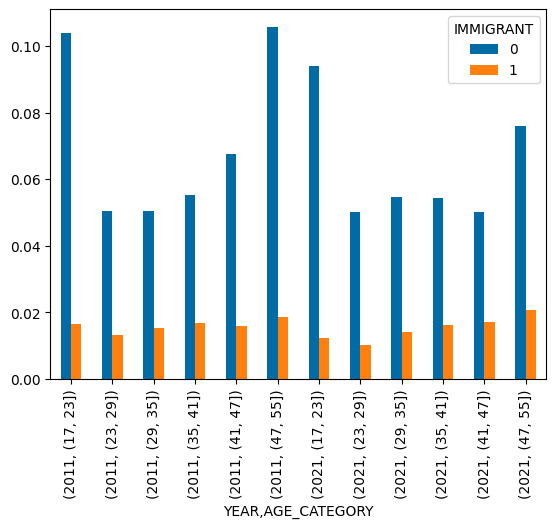

In [80]:
# Number of individuals that reported no income
print((df["INCWAGE_NEW"]==0).sum())
no_inc = df[df["INCWAGE_NEW"]==0]

# Number of no income individuals for immigrants status for each age group and year
no_inc_table = pd.pivot_table(
    no_inc, 
    index="IMMIGRANT", 
    columns=["YEAR", "AGE_CATEGORY"], 
    values="INCWAGE_NEW", 
    aggfunc="count"
) / (df["INCWAGE_NEW"]==0).sum()

print(no_inc_table)
no_inc_table.T.plot(kind="bar")

In [44]:
# See if being an immigrant or not influences na response
non_immigrant_na = group1.WEEKLYEARNINGS.isna().sum()
immigrant_na = group2.WEEKLYEARNINGS.isna().sum()
print(f"non-immigrant na rate: {non_immigrant_na/df.shape[0]}\nimmigrant na rate: {immigrant_na/df.shape[0]}")

non-immigrant na rate: 0.31467454720630017
immigrant na rate: 0.06811588567501216


# Visualization

In [6]:
def modify_axis(ax, grid=True):
    if grid:
        ax.grid(axis='y',zorder=0)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

IMMIGRANT
0    4994782
1    1023080
Name: count, dtype: int64


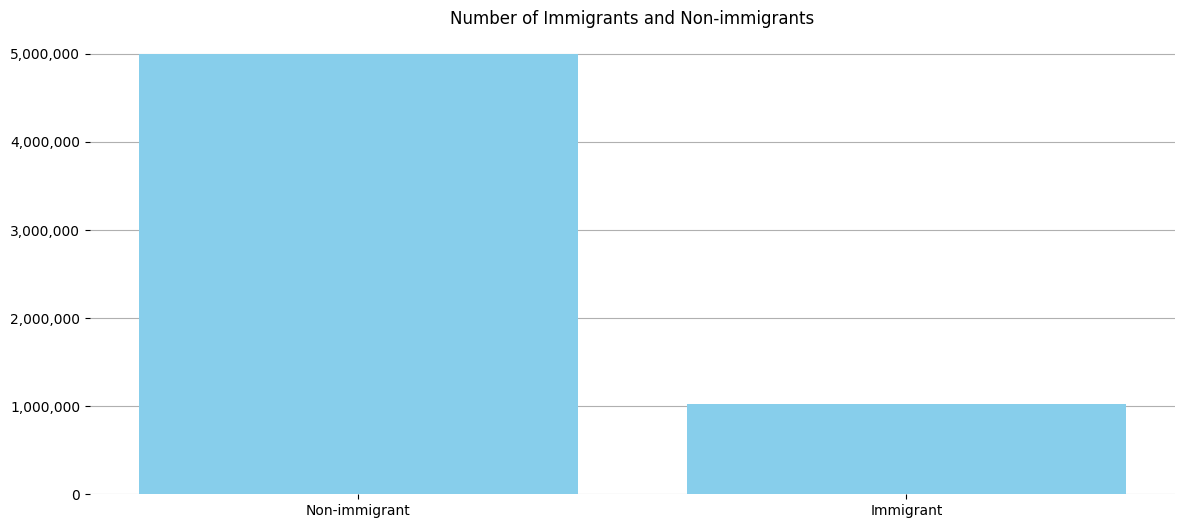

In [7]:
def plot_number_of_immigrants(df, ax):
    """Bar plot for number of immigrants and non-immigrants
    """
    immigrant_counts = df['IMMIGRANT'].value_counts()
    print(immigrant_counts)

    imm_mapping = {0:"Non-immigrant", 1:'Immigrant'}
    immigrant_counts_df = immigrant_counts.reset_index()
    
    # add grid lines and remove axis lines
    modify_axis(ax)
    
    # bar chart
    ax.bar(
        immigrant_counts_df['IMMIGRANT'].map(imm_mapping), 
        immigrant_counts_df['count'], 
        color='skyblue',
        zorder=3
    )
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.set_title('Number of Immigrants and Non-immigrants')
    
fig, ax = plt.subplots(figsize=(14, 6), dpi=100)
plot_number_of_immigrants(df, ax)

In [16]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


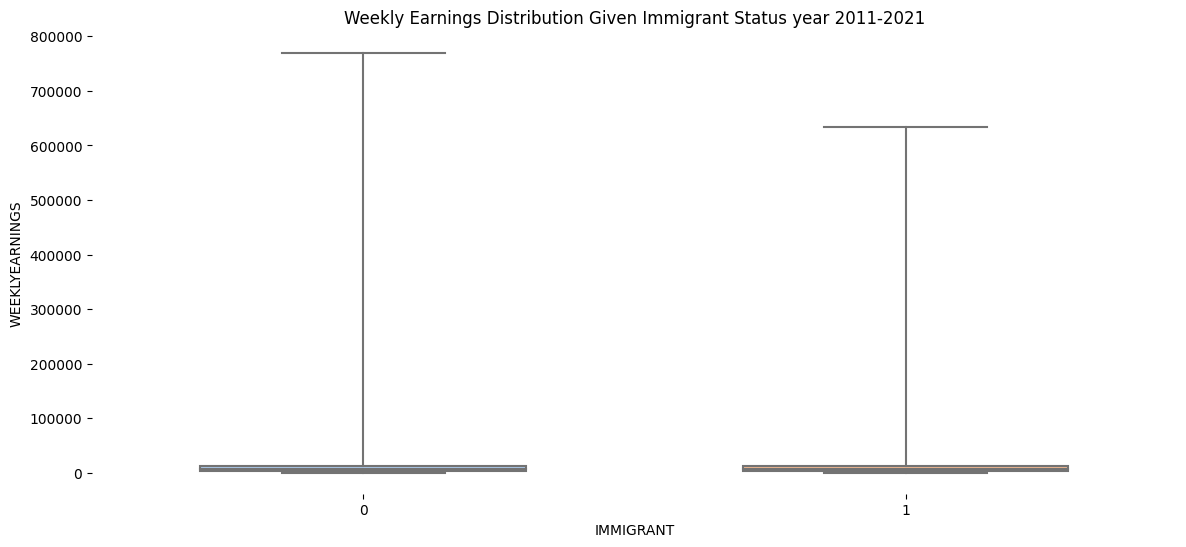

In [10]:
def weekly_earnings_box_plot(ax, df, year):
    modify_axis(ax, grid = False)
    sns.boxplot(x='IMMIGRANT', y='WEEKLYEARNINGS', data=df, whis=[0, 100], width=.6, palette="pastel", ax=ax)
    ax.set_title(f"Weekly Earnings Distribution Given Immigrant Status year {year}")
    
fig, ax = plt.subplots(figsize=(14, 6), dpi=100)
weekly_earnings_box_plot(ax, df, year="2011-2021")

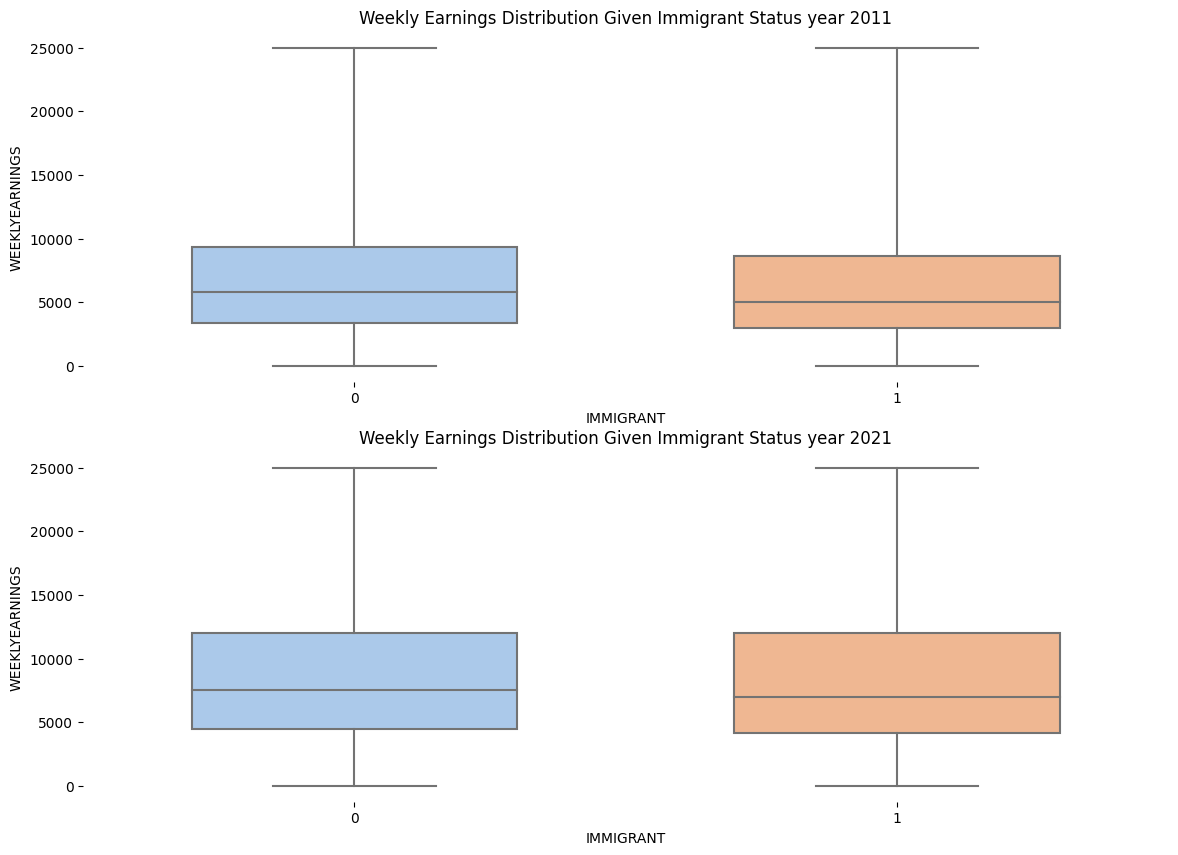

In [68]:
# Can't see much above so we limit the data to 95% percentile
def limit_data(df, variable, percentile):
    im_limit = df[df["IMMIGRANT"] == 1][variable].quantile(percentile)
    non_im_limit =df[df["IMMIGRANT"] == 0][variable].quantile(percentile)
    limit = min(im_limit, non_im_limit)
    return df[df['WEEKLYEARNINGS'] <= limit]
    

df_limited = limit_data(df, "WEEKLYEARNINGS" ,0.95)
# Plot again
fig, axs = plt.subplots(2, 1 ,figsize=(14, 10), dpi=100)
weekly_earnings_box_plot(axs[0], df_limited[df_limited['YEAR']==2011], year=2011)
weekly_earnings_box_plot(axs[1], df_limited[df_limited['YEAR']==2021], year=2021)
# Much better result.

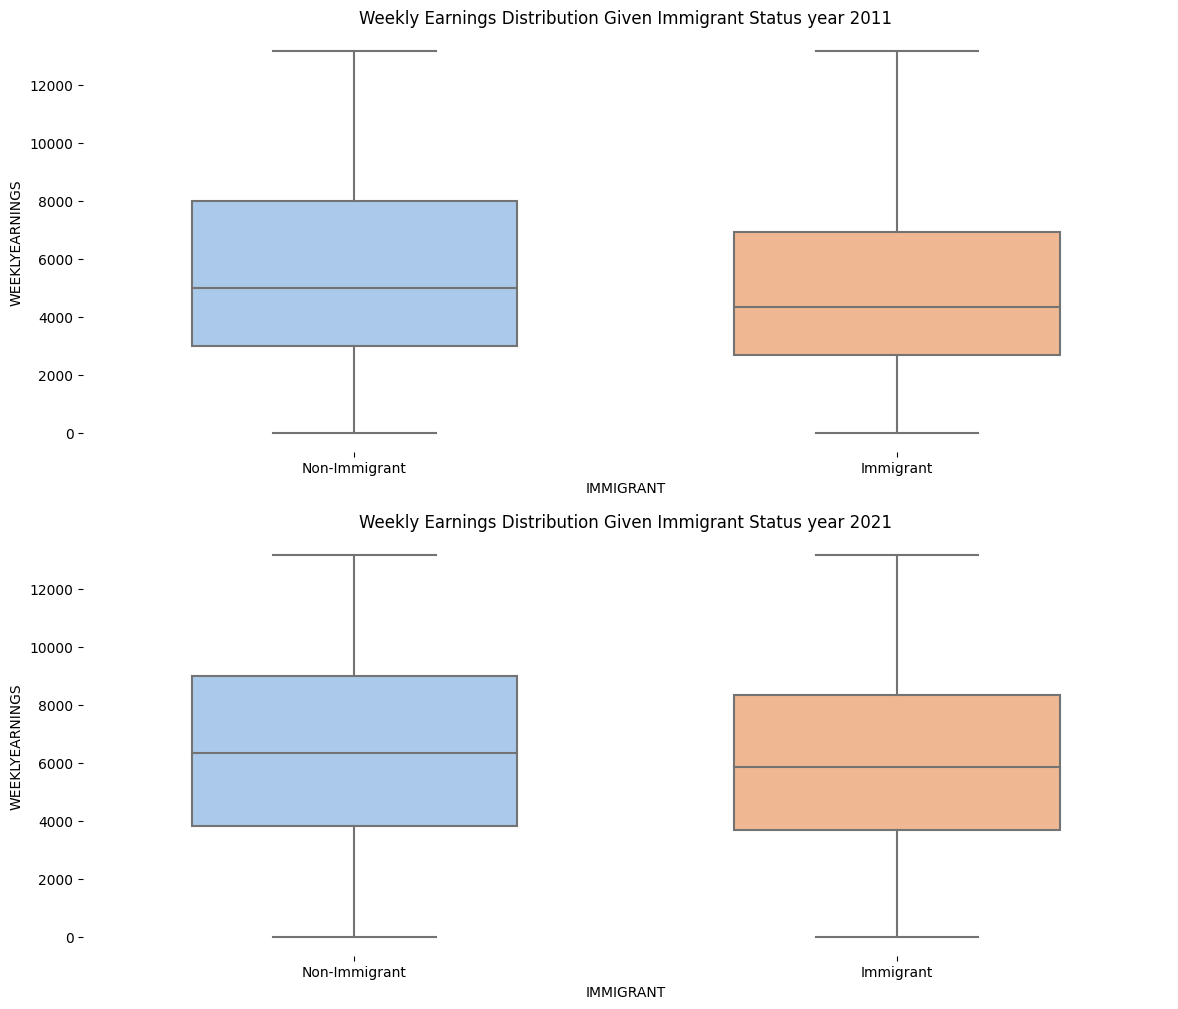

In [90]:
# Limit data a little more to pronouce the difference between being an immigrant or not
df_limited = limit_data(df, "WEEKLYEARNINGS",0.80)
df_limited_renamed = df_limited.copy()
df_limited_renamed.loc[:, "IMMIGRANT"] = df_limited_renamed["IMMIGRANT"].replace(mapping)
# Plot again
fig, axs = plt.subplots(2, 1 ,figsize=(14, 12), dpi=100)
weekly_earnings_box_plot(axs[0], df_limited_renamed[df_limited_renamed['YEAR']==2011], year=2011)
weekly_earnings_box_plot(axs[1], df_limited_renamed[df_limited_renamed['YEAR']==2021], year=2021)
# Looks like immigrant income has caught up to non immigrants 

In [84]:
# Kolmogororov-Smirnov test

def ks_test(df, group1, group2, reference_year, rnv_year):
    reference = df[(df["YEAR"] == reference_year) & (df["IMMIGRANT"] == group1)]['WEEKLYEARNINGS']
    x = df[(df["YEAR"] == rnv_year) & (df["IMMIGRANT"] == group2)]['WEEKLYEARNINGS']
    return stats.kstest(x, reference)

# Kolmogororov-Smirnov test shows that the distributions of weekly income for immigrants does shift in 2021
print(ks_test(df, 1, 1, reference_year=2011, rnv_year=2021))

KstestResult(statistic=0.13061993369958916, pvalue=0.0, statistic_location=6516.6667, statistic_sign=-1)


KstestResult(statistic=0.1062591748614044, pvalue=0.0, statistic_location=8283.3333, statistic_sign=-1)

In [65]:
cpalettle = sns.color_palette("flare", as_cmap=True)

400000.0
215000.0


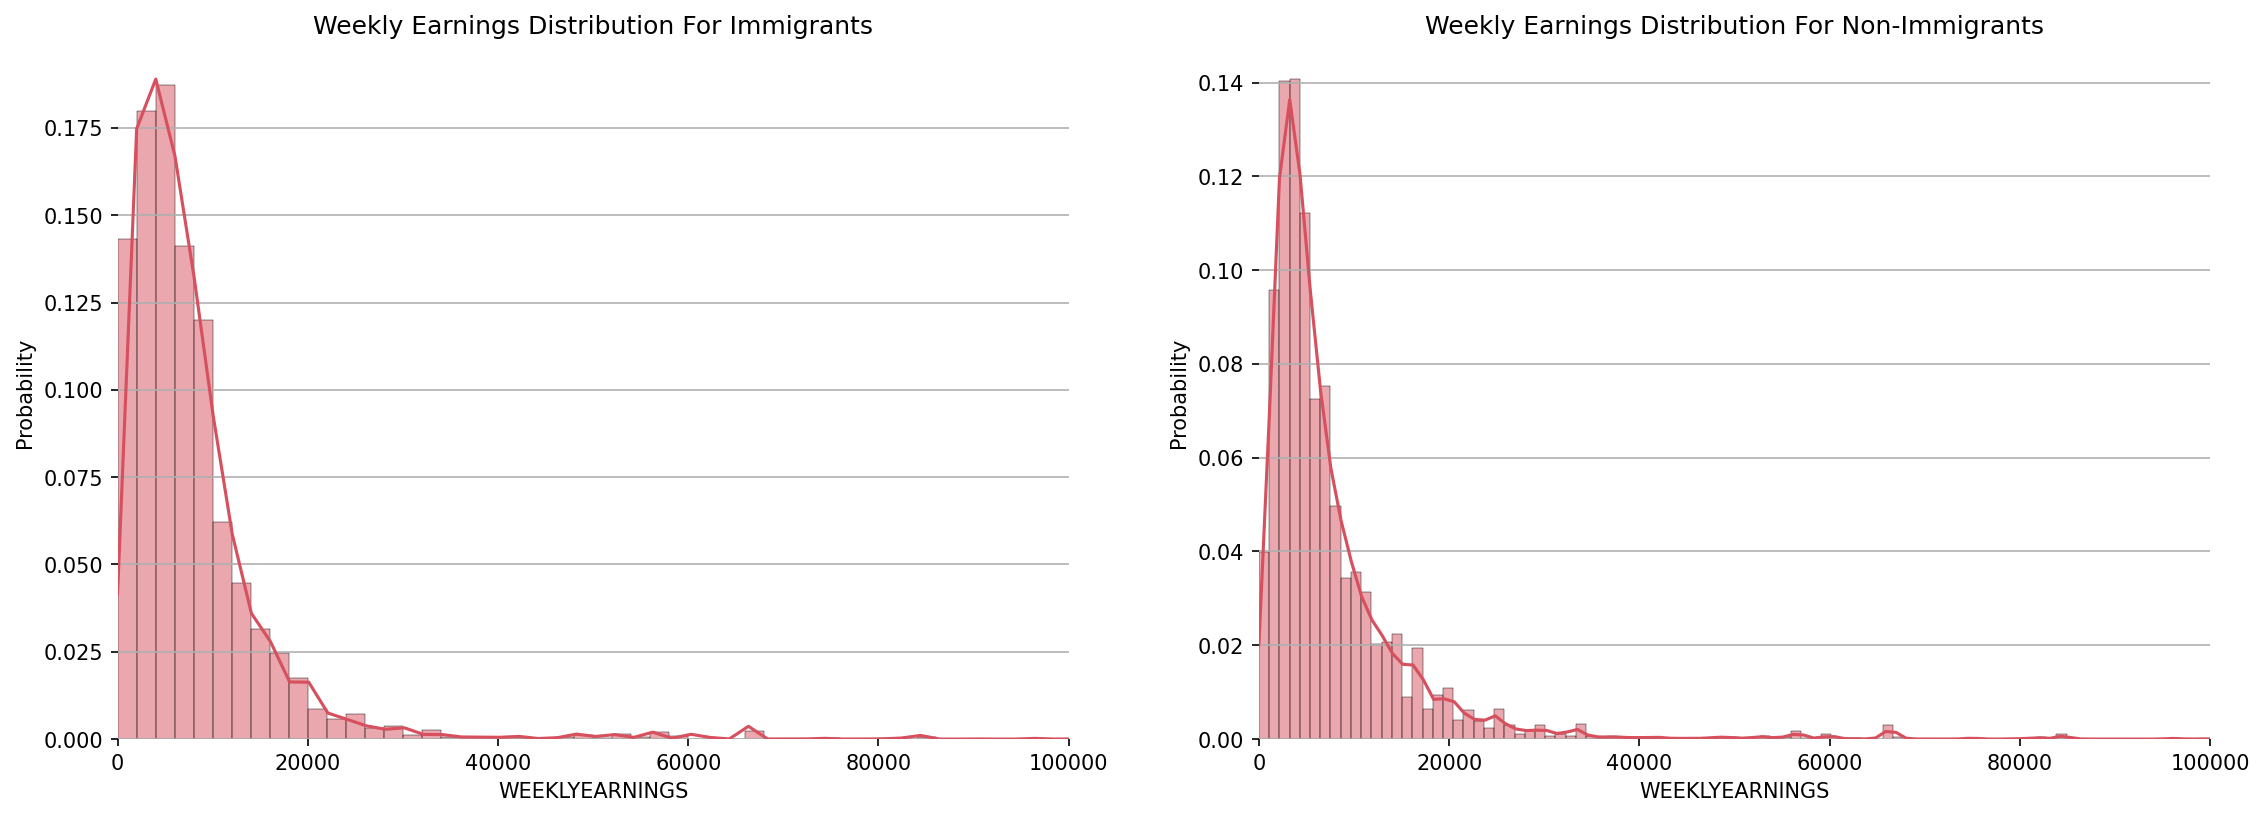

In [92]:
# Plot distributions of weekly earnings 
def plot_earnings_dist(df, log_earnings=False, n_bins=200):
    bins = n_bins
    fig, ax = plt.subplots(1, 2, figsize=(18, 6), dpi=150)
    #palette = sns.color_palette("bright")
    modify_axis(ax[1])
    modify_axis(ax[0])

    for i in range(2):
        data = df.loc[df["IMMIGRANT"]==i, "WEEKLYEARNINGS"].dropna()
        data = data if not log_earnings else np.log(data)
        sns.histplot(
            data=data, 
            kde=True, 
            ax=ax[i], 
            color = cpalettle.colors[100], 
            bins=bins, 
            stat="probability"
        )
        # zoom in a little. There are very large outliers making plot hard to see
        if not log_earnings:
            ax[i].set_xlim(0, 100000)


    ax[1].yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    ax[0].set_title("Weekly Earnings Distribution For Immigrants")
    ax[1].set_title("Weekly Earnings Distribution For Non-Immigrants")


    for i in range(2):
        print(df.loc[df["IMMIGRANT"]==i, "WEEKLYEARNINGS"].max())

# 2011
# The kernel density esitimate kind of looks like a gamma or log normal distribution?
plot_earnings_dist(df[df['YEAR']==2011])

770000.0
634000.0


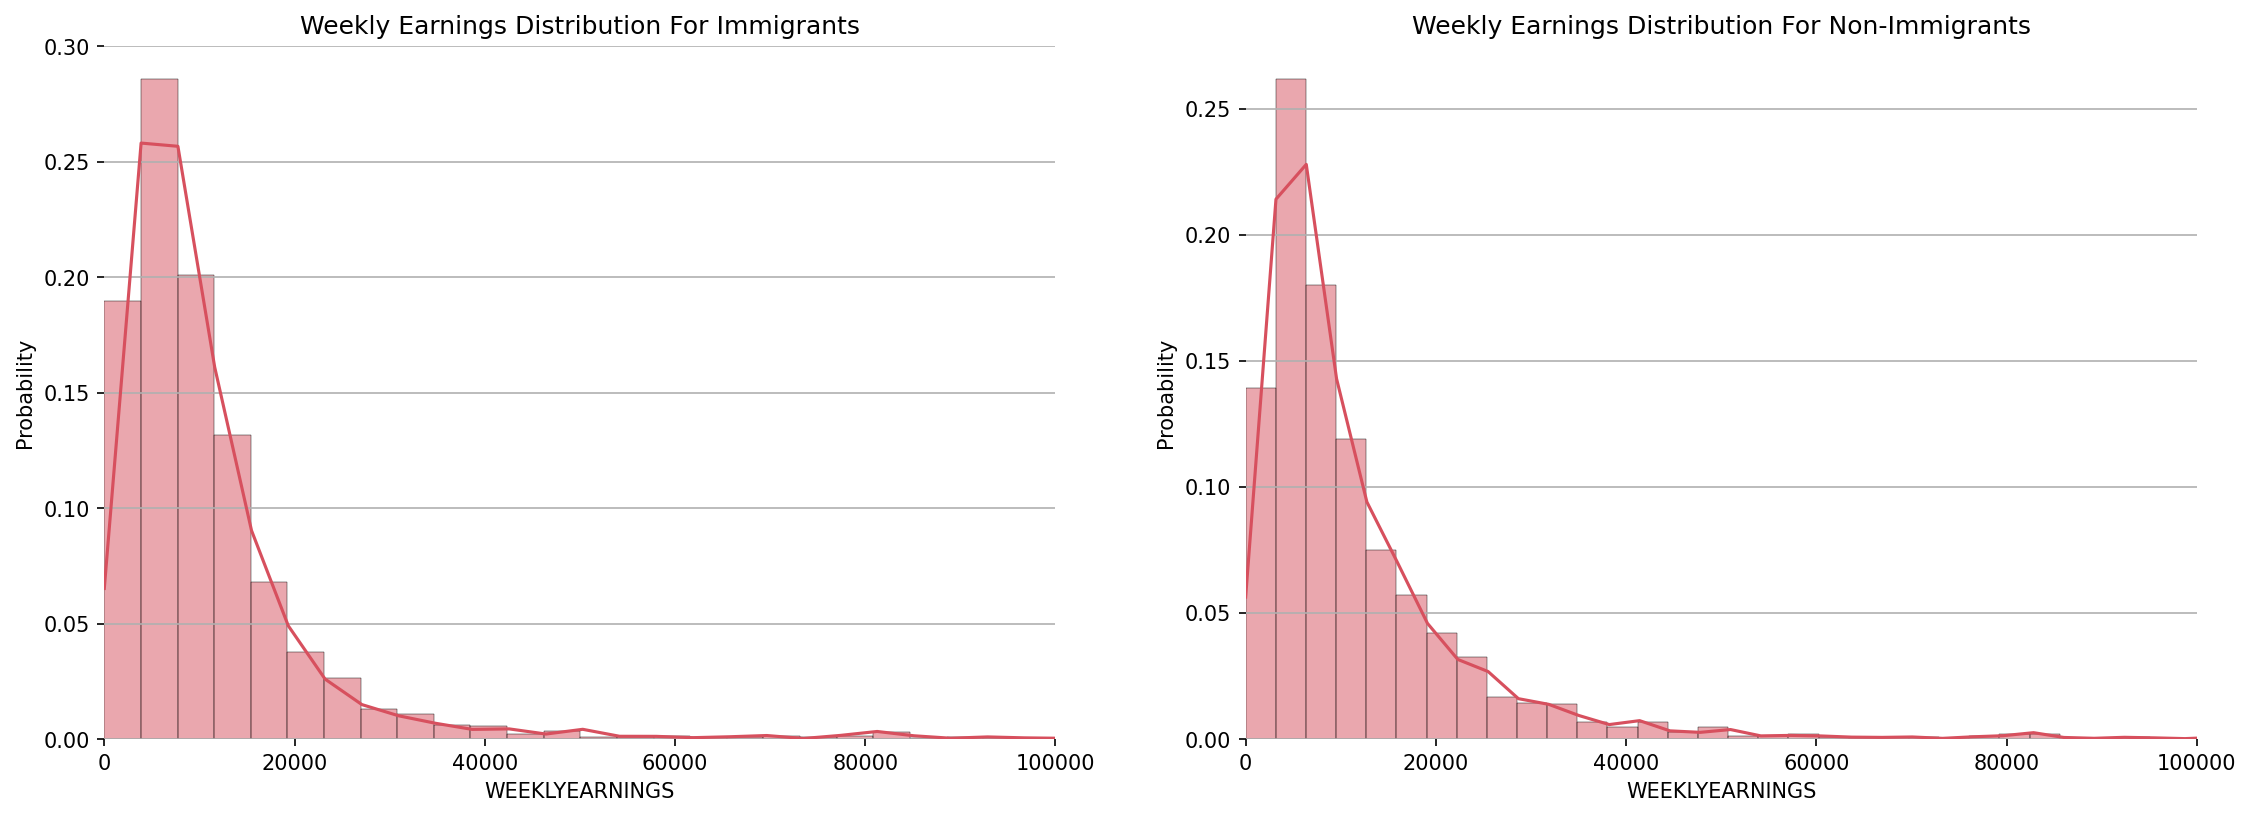

In [42]:
# 2021
plot_earnings_dist(df[df['YEAR']==2021])

770000.0
634000.0


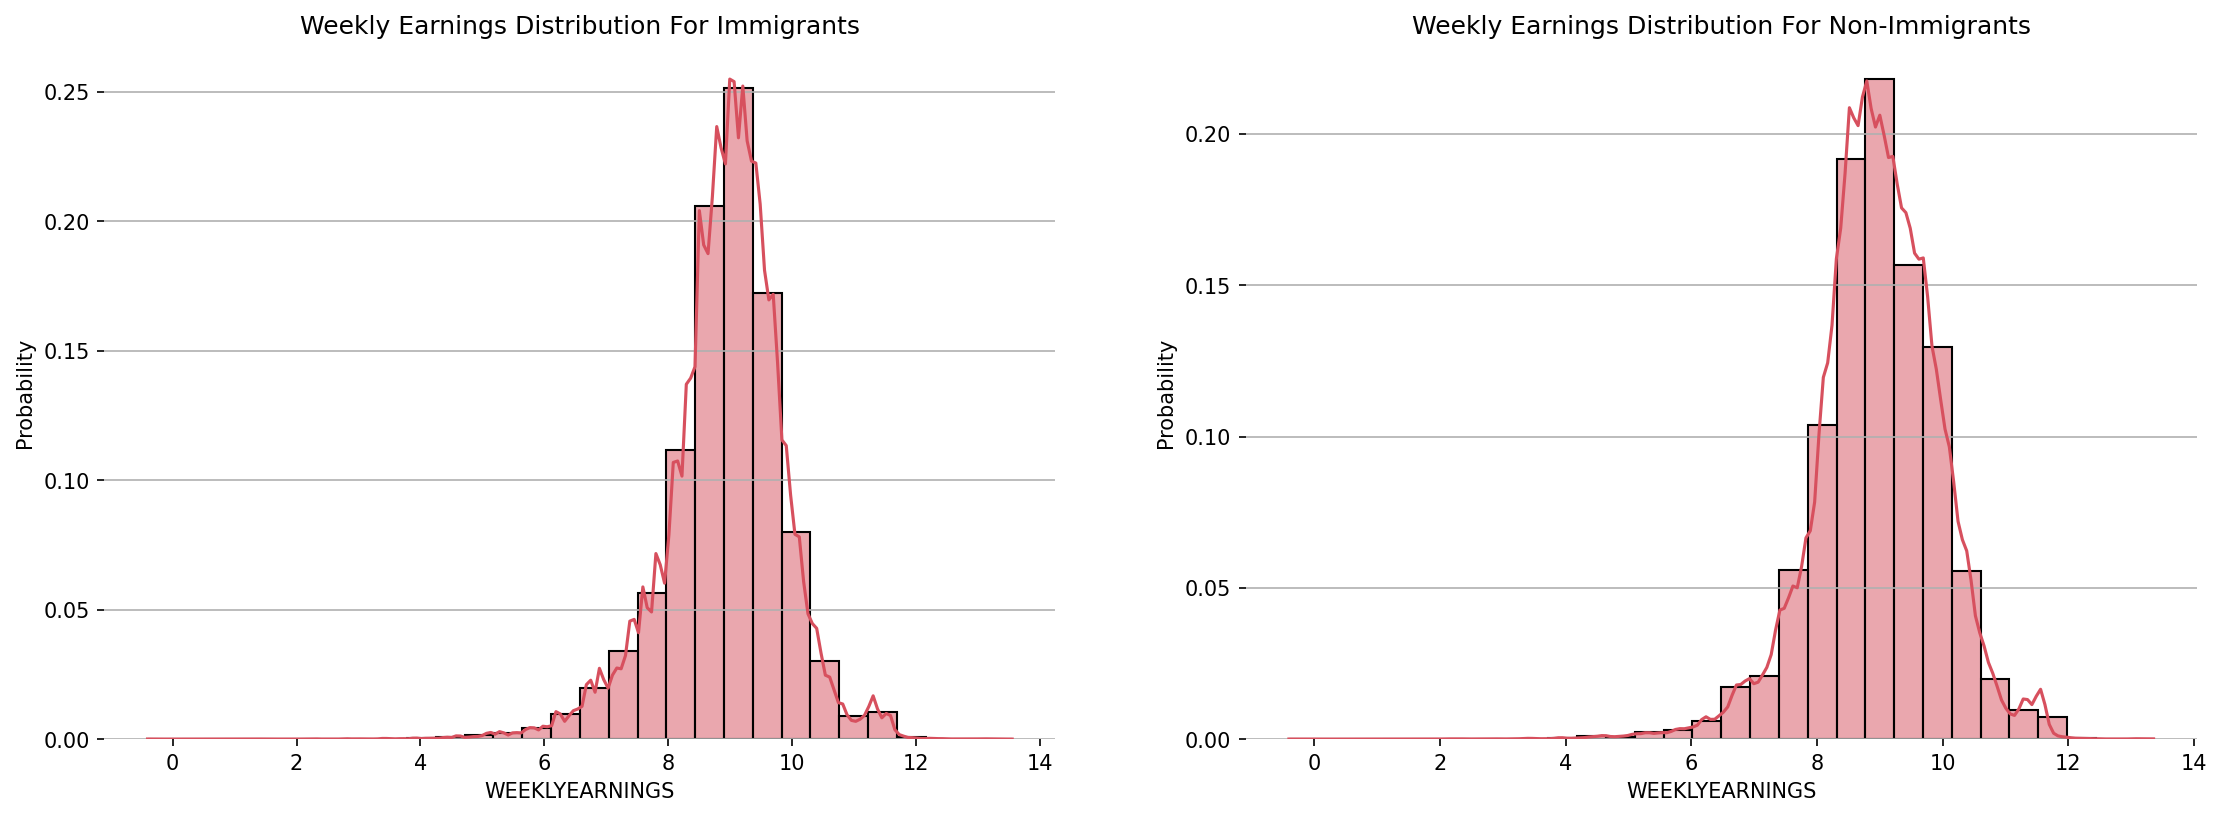

In [93]:
# Log transform data
plot_earnings_dist(df[df['YEAR']==2021], log_earnings=True, n_bins=30)

### Find MLE for $WEEKLYEARINGS | IMMIGRANT = 0 \sim LOGNORMAL(\mu, \sigma)$ 

In [107]:
# Fit a log normal distribution to non-immigrant data in 2021
measurements = limit_data(df, 0.80)
measurements = measurements[(measurements["IMMIGRANT"] == 0) & (measurements["YEAR"] == 2021)].WEEKLYEARNINGS.dropna()
res = stats.lognorm.fit(measurements)
print(res)

(0.07956508417973387, -35699.93735788072, 41971.431569230335)


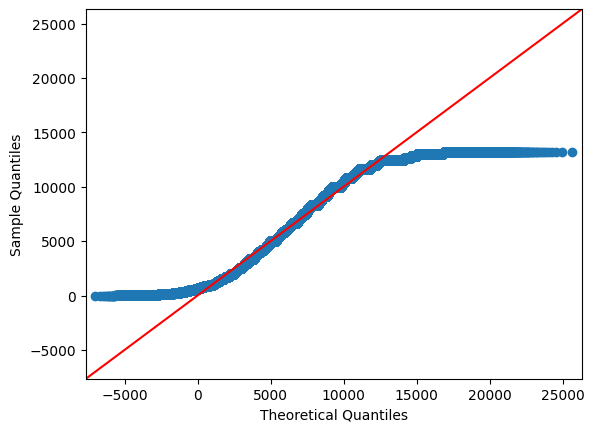

In [108]:
plot = sm.qqplot(
    measurements, 
    dist=stats.lognorm, 
    distargs=(res[0],), 
    scale=res[2], 
    loc=res[1], line="45"
)

In [ ]:
# Looks like a log-normal distribution is a good fit between income of 0 and between 10,000 and 15,000

In [94]:
# Log the data and see how it fits a normal density.
mu, sigma = stats.norm.fit(np.log(measurements))

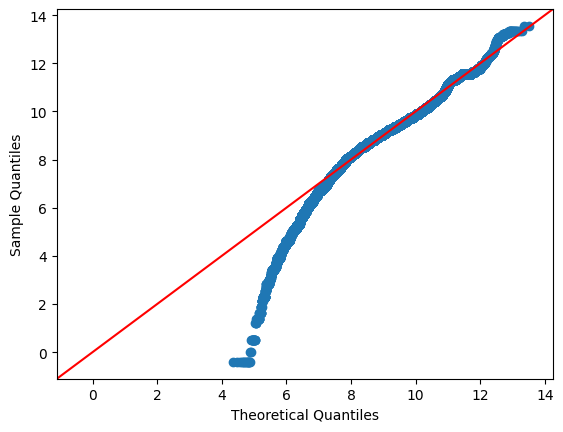

In [95]:
plot = sm.qqplot(
    np.log(measurements), 
    dist=stats.norm, 
    scale=sigma,
    loc=mu, 
    line="45"
)

In [110]:
# alternatively:
def get_avg_wklyearnings_sql():
    avg_wklyearnings_sql = """
    SELECT AVG(d.WEEKLYEARNINGS) FROM
    (SELECT d.WEEKLYEARNINGS, @rownum:=@rownum+1 as `row_number`, @total_rows:=@rownum
      FROM acs.acs d, (SELECT @rownum:=0) r
      WHERE d.WEEKLYEARNINGS is NOT NULL
      ORDER BY d.WEEKLYEARNINGS)
      WHERE d.WEEKLYEARNINGS IN (FLOOR((@total_rows + 1)/2), FLOOR(@total_rows/2));
    """
    return pd.read_sql(avg_wklyearnings_sql, db)

#avg_wklyearnings = get_avg_wklyearnings_sql()

def plot_avg_wklyearnings(df_, ax):
    """Bar plot for weekly earnings per year for immigrants/non immigrants
    """
    # calculate average weakly earnings for immigrants using median since we have huge skewness
    avg_wklyearnings = df_.groupby(['IMMIGRANT', 'YEAR'])[['WEEKLYEARNINGS']].median()
    avg_wklyearnings.rename({"WEEKLYEARNINGS": "Average weekly earnings"}, axis=1, inplace=True)
    modify_axis(ax)
    
    years = [2011, 2021]
    
    x = np.arange(2)  # the label locations
    width = 0.4  # the width of the bars
    multiplier = 0
    
    # plot bar chart groups
    for imm in [0, 1]:
        offset = width * multiplier
        rects = ax.bar(
            x + offset, 
            avg_wklyearnings.loc[imm]["Average weekly earnings"], 
            width, 
            label = "Immigrant" if imm == 1 else "Non-immigrant",
            zorder = 3
        )
        ax.bar_label(rects, padding=3)
        multiplier += 1
        
    ax.set_xticks(x + (width/2), years)
    ax.set_facecolor('white')
    ax.legend()
    ax.set_title("Average Weekly Earnings For Immigrants/Non Immigrants by Year")


In [63]:
# Pivot table of weekly earnings for each year and immigrant status.
table = pd.pivot_table(df.dropna(), values="WEEKLYEARNINGS", columns="YEAR", aggfunc='median', index="IMMIGRANT")
table.index = table.reset_index()["IMMIGRANT"].replace(mapping)
                
print(table)

YEAR             2011       2021
IMMIGRANT                       
Non-Immigrant  6000.0  8333.3333
Immigrant      5000.0  8166.6667


IMMIGRANT
0    4994782
1    1023080
Name: count, dtype: int64


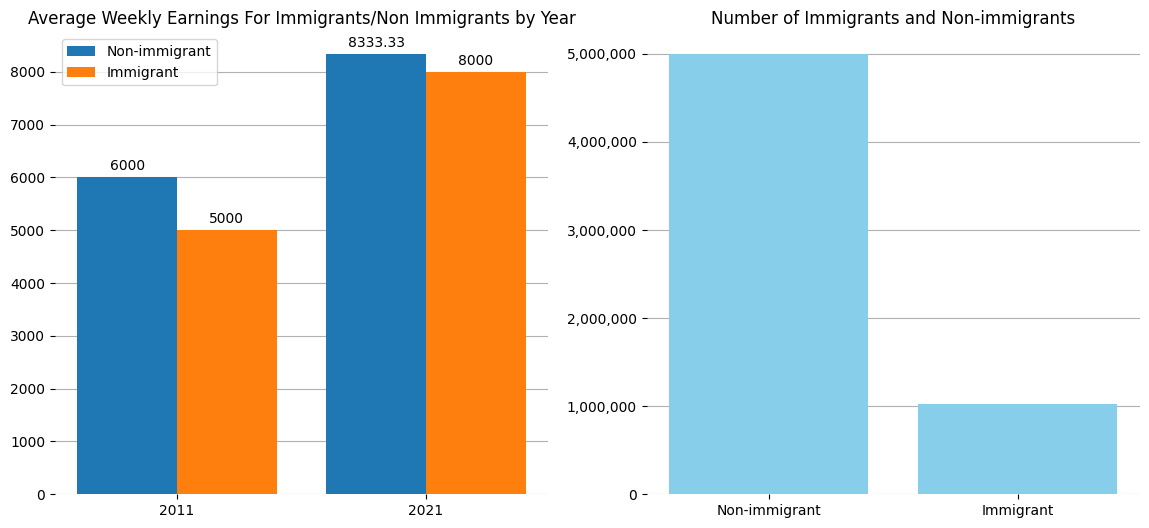

In [111]:
# plot
fig, ax = plt.subplots(1, 2, figsize=(14, 6), dpi=100)
plot_avg_wklyearnings(df, ax[0])
plot_number_of_immigrants(df, ax[1])

In [104]:
def fix_imm_index(df):
    """
    Assuming Immigrant is the index
    """
    df.index = df.reset_index()["IMMIGRANT"].replace(mapping)
    return df

YEAR          2011     2021
IMMIGRANT                  
0          2550012  2444770
1           502948   520132
YEAR
2011    3052960
2021    2964902
dtype: int64


<Axes: xlabel='IMMIGRANT'>

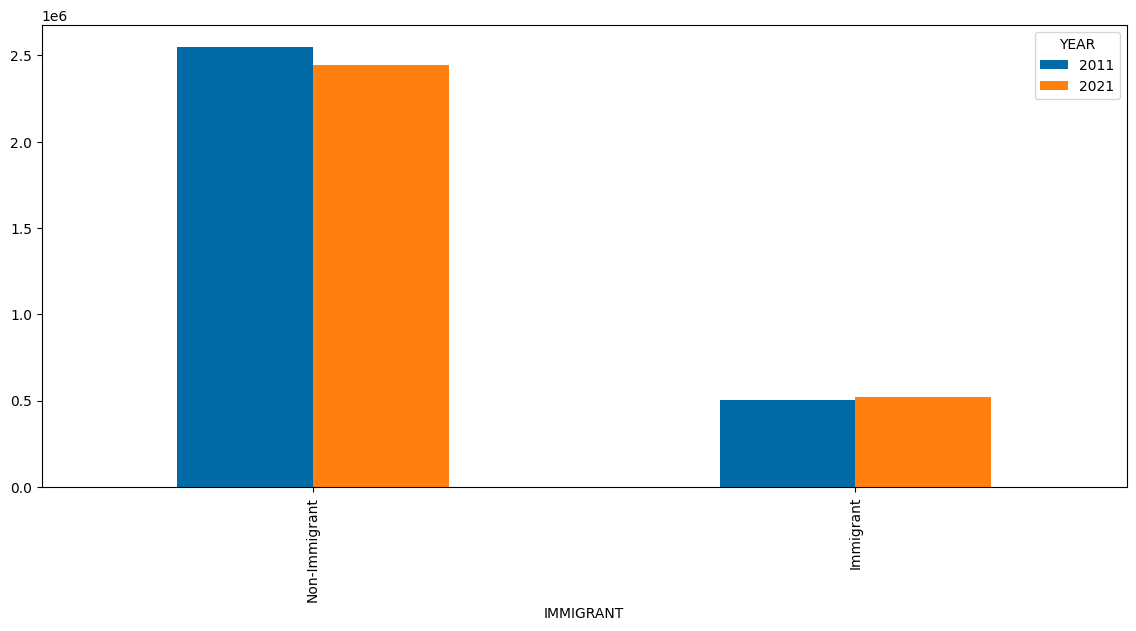

In [112]:
# Study immigrant status over time
im_status_year = pd.pivot_table(df, index="IMMIGRANT", columns="YEAR", values="AGE", aggfunc="count")
print(im_status_year)
print(im_status_year.sum())
im_status_year = fix_imm_index(im_status_year)
fig, ax = plt.subplots(figsize=(14, 6), dpi=100)
im_status_year.plot(kind="bar", ax=ax)

In [ ]:
# The amount of immigrants vs non immigrants sampled did not really change significantly 

In [51]:
# Check if medians are similar
year = 2021
res_2021  = stats.median_test(
    group1[group1['YEAR']==year].WEEKLYEARNINGS.dropna(),
    group2[group2['YEAR']==year].WEEKLYEARNINGS.dropna()
)

print(f"Median test results for {year}", res_2021)

year = 2011
res_2011  = stats.median_test(
    group1[group1['YEAR']==year].WEEKLYEARNINGS.dropna(),
    group2[group2['YEAR']==year].WEEKLYEARNINGS.dropna()
)

print(f"Median test results for {year}", res_2011)

Median test results for 2021 MedianTestResult(statistic=210.6674008291605, pvalue=9.823334598824364e-48, median=8300.0, table=array([[754802, 149336],
       [747710, 156702]], dtype=int64))
Median test results for 2011 MedianTestResult(statistic=5292.018717638273, pvalue=0.0, median=5833.3333, table=array([[807832, 133196],
       [790770, 173934]], dtype=int64))


### Study how education relates to immigration and earnings

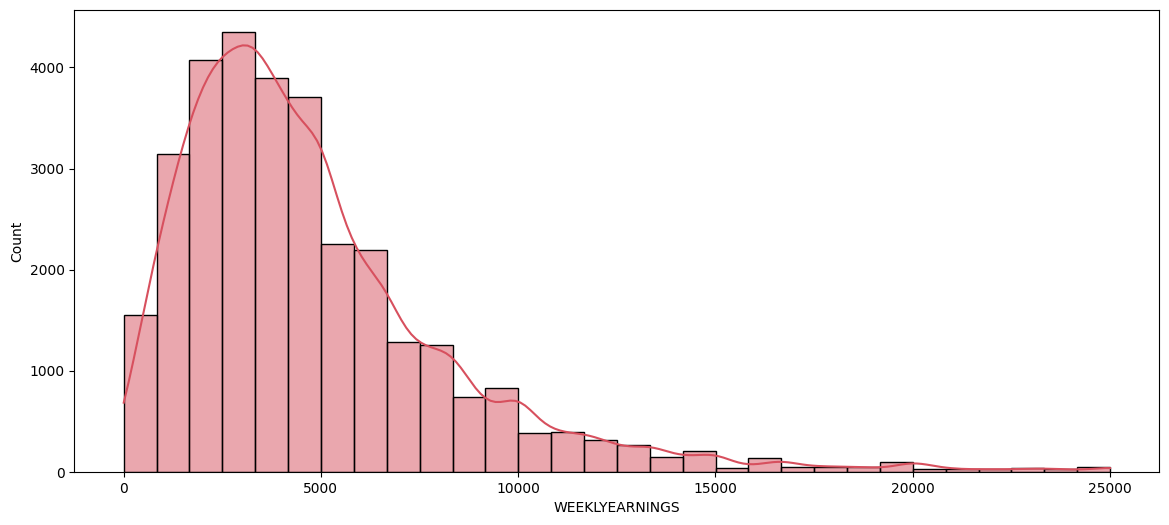

In [74]:
def plot_weeklyearnings_given_grade(df, grade:str, n_bins, xmin=0, xmax=None):
    fig, ax = plt.subplots(figsize=(14, 6), dpi=100)
    sns.histplot(data=df.loc[df["GRADE"]==grade, "WEEKLYEARNINGS"], kde=True, ax=ax, color = cpalettle.colors[100], bins=n_bins)
    if xmax:
        ax.set_xlim(xmin, xmax)
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))

# grades=# of years of school
# Weekly earnings given grades looks to be gamma distributed 
# Limit data for visability purposes 
df_limited = limit_data(df, "WEEKLYEARNINGS", 0.95)
plot_weeklyearnings_given_grade(df_limited, "10", 30)


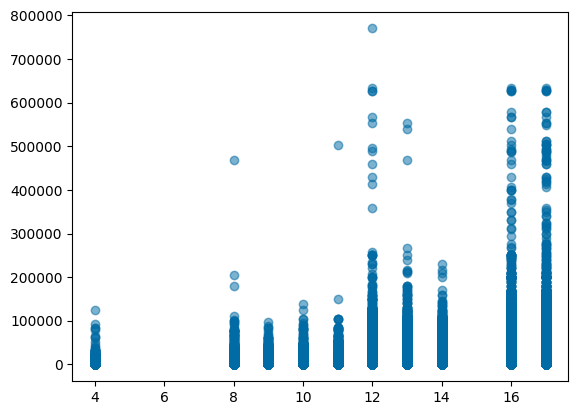

In [87]:
df_no_na = df.dropna()
plt.scatter(
    x=df_no_na["GRADE"].astype(int), 
    y=df_no_na['WEEKLYEARNINGS'],
    alpha=0.3
)

Text(0.5, 1.0, 'Average Weekly Earnings by Amount of School in Years')

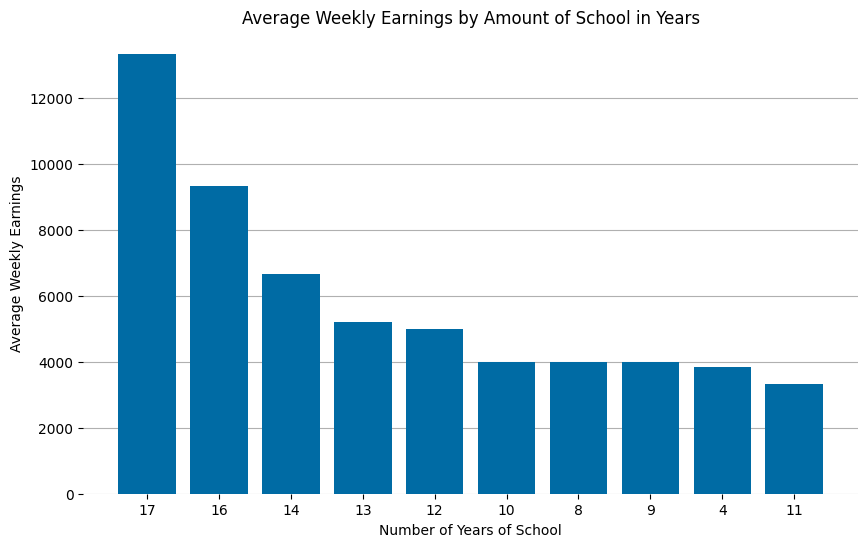

In [75]:
# plot weekly earnings for each number of years of school
weeklyearnings_by_grade = df.groupby(['GRADE'])[['WEEKLYEARNINGS']].median().sort_values(by="WEEKLYEARNINGS", ascending=False)
fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
modify_axis(ax)
ax.bar(weeklyearnings_by_grade.index, 
       weeklyearnings_by_grade['WEEKLYEARNINGS'], 
       zorder=3)

ax.set_xlabel("Number of Years of School")
ax.set_ylabel('Average Weekly Earnings')
ax.set_title("Average Weekly Earnings by Amount of School in Years")

In [100]:
print(df.GRADE.value_counts())
grade_table = pd.pivot_table(df, index="GRADE", values="WEEKLYEARNINGS", columns="YEAR", aggfunc="count")
grade_table.index = grade_table.index.astype(int)
grade_table.sort_index(inplace=True)
grade_table.index.name = "Years of school"

print(grade_table)
print(grade_table[grade_table[2011] < grade_table[2021]])

# We see that almost every number of years of schooling decreased in 2021 except 16, 17 years

GRADE
12    2140842
16    1185062
13     984460
17     650788
14     500960
11     162060
8      119254
10      95796
9       77504
4       22624
Name: count, dtype: int64
YEAR               2011    2021
Years of school                
4                  6474    3688
8                 32346   18240
9                 18798   10140
10                21270   10580
11                33270   19536
12               637316  524500
13               332560  247794
14               180194  173124
16               407710  478338
17               224284  305836
YEAR               2011    2021
Years of school                
16               407710  478338
17               224284  305836
